<a href="https://colab.research.google.com/github/ethan060626/generative_ai/blob/main/week11HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📚 打造 Stable Diffusion 的 WebUI

### 1. 安裝必要套件

In [1]:
!pip install diffusers transformers accelerate safetensors huggingface_hub gradio --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.3/484.3 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211

In [2]:
# from google.colab import userdata

# hf_token = userdata.get("HuggingFace")
# login(token=hf_token)

In [3]:
from diffusers import StableDiffusionPipeline, UniPCMultistepScheduler
import torch
import gc
import matplotlib.pyplot as plt
import gradio as gr
import random

### 2. 指定並讀入模型

In [4]:
model_name = "Lykon/dreamshaper-8"

注意有可能要停用 `use_safetensors=True`。

In [5]:
pipe = StableDiffusionPipeline.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    use_safetensors=True
).to("cuda")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/520 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/796 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/724 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/756 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.87k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [6]:
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

### 3. 生成的函式

In [7]:
def generate_images(prompt, use_enhance, enhance_text, use_negative, negative_text,
                    use_custom_seed, custom_seed, height, width, steps, num_images):

    height = int(height)
    width = int(width)

    if height % 8 != 0 or width % 8 != 0:
        raise ValueError("高度和寬度必須是8的倍數！")

    if use_custom_seed:
        base_seed = int(custom_seed)
    else:
        base_seed = random.randint(0, 2**32 - 1)

    seeds = [base_seed + i for i in range(num_images)]

    prompts = []
    negative_prompts = []
    generators = []

    final_prompt = prompt
    if use_enhance and enhance_text:
        final_prompt = prompt + ", " + enhance_text

    final_negative = negative_text if use_negative else None

    for seed in seeds:
        g = torch.Generator("cuda").manual_seed(seed)
        generators.append(g)
        prompts.append(final_prompt)
        negative_prompts.append(final_negative)

    gc.collect()
    torch.cuda.empty_cache()

    images = []
    for i in range(num_images):
        with torch.no_grad():
            image = pipe(
                prompt=prompts[i],
                negative_prompt=negative_prompts[i] if final_negative else None,
                height=height,
                width=width,
                num_inference_steps=steps,
                guidance_scale=7.5,
                generator=generators[i]
            ).images[0]
            images.append(image)

    return images, f"使用的 random seeds: {seeds}"

### 4. 打造 Gradio Web App

In [9]:
default_enhance = "masterpiece, ultra high quality, intricate skin details, cinematic lighting"
default_negative = "bad anatomy, blurry, disfigured, poorly drawn hands, extra fingers, mutated hands, low quality, worst quality"

with gr.Blocks(css=".gradio-container {background-color: #FAFAFA; padding: 20px;} .gr-button {font-size: 18px; background: linear-gradient(to right, #667eea, #764ba2); color: white;}") as demo:
    gr.Markdown("""
    # 🎨 MajicMIX v6 互動圖像生成器
    歡迎使用！輸入提示詞、選擇設定，立即生成你的作品！
    """)

    with gr.Row():
        with gr.Column(scale=6):
            prompt = gr.Textbox(label="Prompt", placeholder="請輸入你的提示詞 (prompt)", lines=3)
            with gr.Row():
                use_enhance = gr.Checkbox(label="加強 Prompt", value=True)
                enhance_text = gr.Textbox(label="加強內容", value=default_enhance)
            with gr.Row():
                use_negative = gr.Checkbox(label="使用 Negative Prompt", value=True)
                negative_text = gr.Textbox(label="Negative Prompt 內容", value=default_negative)
            with gr.Row():
                use_custom_seed = gr.Checkbox(label="自訂 Random Seed", value=False)
                custom_seed = gr.Number(label="指定 seed (選填)", value=42)
            with gr.Row():
                height = gr.Dropdown(["512", "768", "1024"], label="高度 Height", value="512")
                width = gr.Dropdown(["512", "768", "1024"], label="寬度 Width", value="512")
            with gr.Row():
                steps = gr.Slider(10, 50, value=20, step=5, label="生成步數 (Steps)")
                num_images = gr.Slider(1, 4, step=1, value=1, label="生成張數")
            generate_btn = gr.Button("🚀 開始生成！")

        with gr.Column(scale=6):
            gallery = gr.Gallery(label="生成結果", columns=2, object_fit="contain", height="auto")
            seed_info = gr.Label(label="使用的 Random Seeds")

    generate_btn.click(
        fn=generate_images,
        inputs=[prompt, use_enhance, enhance_text, use_negative, negative_text,
                use_custom_seed, custom_seed, height, width, steps, num_images],
        outputs=[gallery, seed_info]
    )

In [ ]:
demo.launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://7c85437aac71693694.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

promt:cake
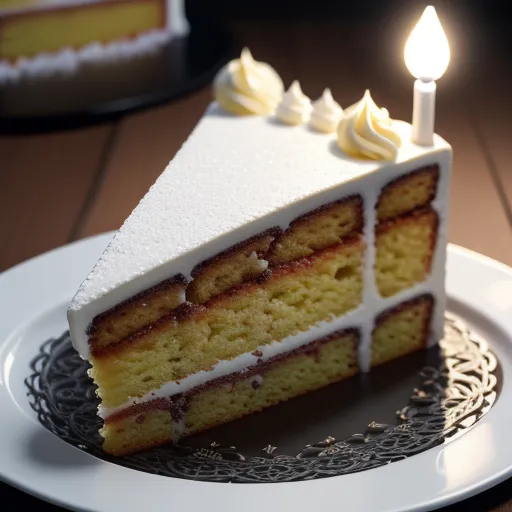

promt:chocolate cake
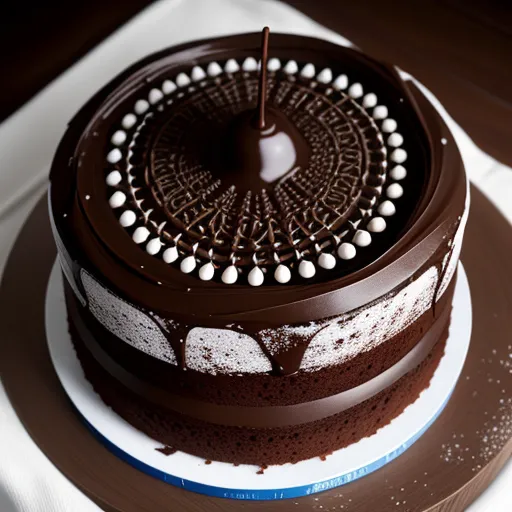

promt:small chocolate cake
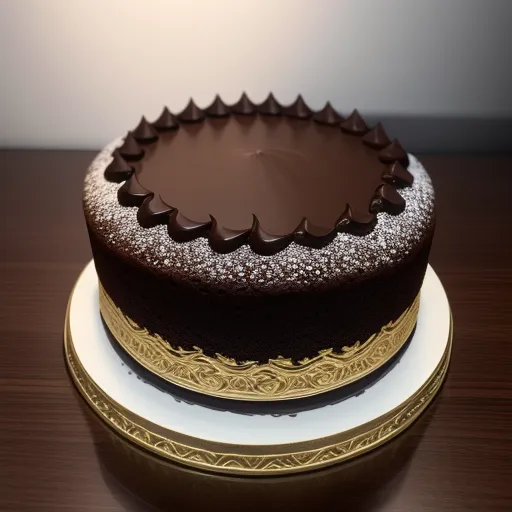

promt:mini chocolate cake
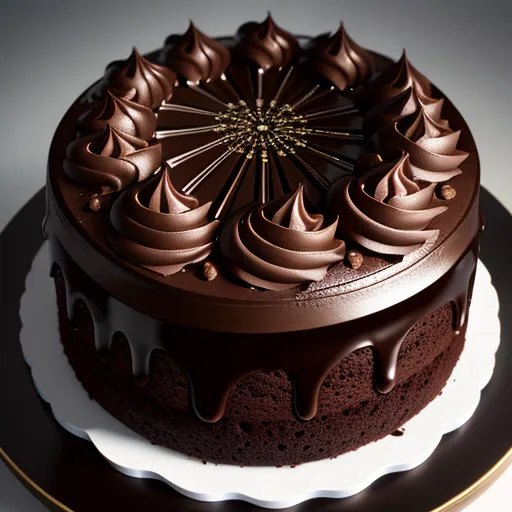